In [8]:
import cv2
import numpy as np
import math
import math
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import random
import core

In [9]:
def psnr(img1, img2):
   mse = np.mean((img1 - img2) ** 2 )
   if mse < 1.0e-10:
      return 100
   return 10 * math.log10(255.0**2/mse)

def ssim(img1, img2):
  C1 = (0.01 * 255)**2
  C2 = (0.03 * 255)**2
  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  kernel = cv2.getGaussianKernel(11, 1.5)
  window = np.outer(kernel, kernel.transpose())
  mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5] # valid
  mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
  mu1_sq = mu1**2
  mu2_sq = mu2**2
  mu1_mu2 = mu1 * mu2
  sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
  sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
  sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
  ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                              (sigma1_sq + sigma2_sq + C2))
  return ssim_map.mean()

def calculate_ssim(img1, img2):
  '''calculate SSIM
  the same outputs as MATLAB's
  img1, img2: [0, 255]
  '''
  if not img1.shape == img2.shape:
    raise ValueError('Input images must have the same dimensions.')
  if img1.ndim == 2:
    return ssim(img1, img2)
  elif img1.ndim == 3:
    if img1.shape[2] == 3:
      ssims = []
      for i in range(3):
        ssims.append(ssim(img1, img2))
      return np.array(ssims).mean()
    elif img1.shape[2] == 1:
      return ssim(np.squeeze(img1), np.squeeze(img2))
  else:
    raise ValueError('Wrong input image dimensions.')
    
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
def predresult(model,img):
    model.eval()
    pred_score = model(img)
    return pred_score.argmax(1)

def mycompare(a, b):
    index = 0
    size = a.shape
    for x, y in zip(a, b):
        if x==y:
            index += 1
    return index/size[0]

def test_model(dataloader, model):
    size = len(dataloader.dataset)
    # num_batches = len(dataloader)
    model.eval()
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%\n")

def fragileimg(Test_img):
    Test_img.requires_grad = True
    outputs = target_model(Test_img)
    cost = -torch.mean(torch.var(soft_max(outputs)))
    # 计算梯度
    grad = torch.autograd.grad(cost, Test_img,
                               retain_graph=False, create_graph=False)[0]
    eps = 0.0001 #cifar10
    # 迭代图片
    Test_img = Test_img + eps * grad.sign()
    Test_img = torch.clamp(Test_img, min=0, max=1).detach()#cifar & mnist
    return Test_img

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
setup_seed(666)

Using cuda device


# 加载演示模型：resnet50-CIFAR10

In [10]:
target_model = core.models.ResNet(50)
target_model.to(device)
target_model.load_state_dict(torch.load('./tests/experiments/ResNet-50_CIFAR-10/ckpt_epoch_100.pth'))

<All keys matched successfully>

# 加载演示数据集：CIFAR10

In [11]:
batch_size = 1 
tr_transformer = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),  # 先四周填充0，在吧图像随机裁剪成32*32
    # transforms.RandomHorizontalFlip(),  # 图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # R,G,B每层的归一化用到的均值和方差
])
te_transformer = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # R,G,B每层的归一化用到的均值和方差
])
training_data = datasets.CIFAR10(root='./datasets', train=True, download=True, transform=te_transformer)
test_data = datasets.CIFAR10(root='./datasets', train=False, download=True, transform=te_transformer)
train_dataloader = DataLoader(training_data, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


# 展示部分正常的训练样本并记录

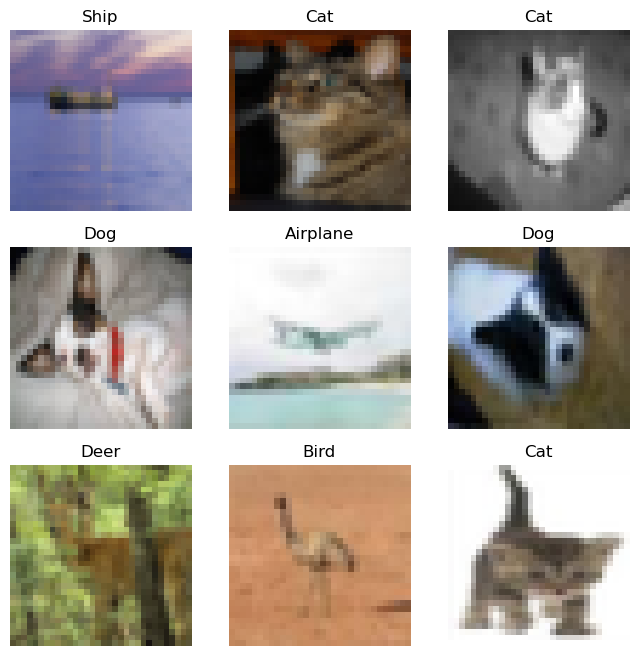

torch.Size([9, 3, 32, 32])


In [12]:
import matplotlib.pyplot as plt
labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    if i==1:
        Original_img = torch.unsqueeze(img,dim=0)
    else:
        Original_img = torch.cat((Original_img,torch.unsqueeze(img,dim=0)),0)
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze())
plt.show()
print(Original_img.shape)


# 原始图像在演示模型中的预测概率直方图

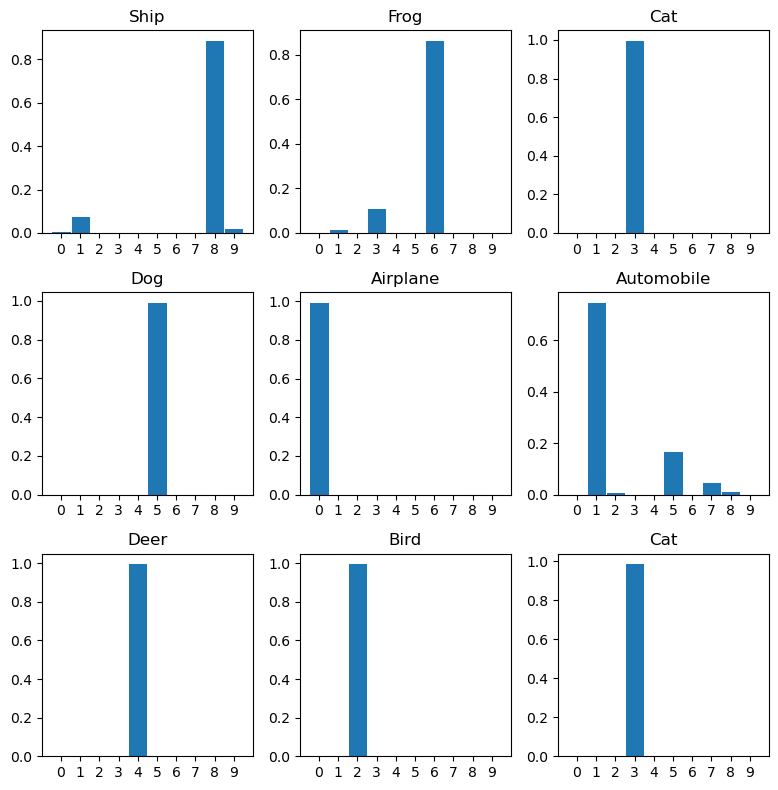

In [13]:
soft_max = nn.Softmax(dim=1)
l_x = ['0','1','2','3','4','5','6','7','8','9']
yticks = np.linspace(0, 1., 5)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
pred = target_model(Original_img.to(device))
Original_label_value = soft_max(pred).detach().cpu().numpy()
Original_label = soft_max(pred).argmax(1).detach().cpu().numpy()
for i in range(1, cols * rows + 1):
    label = Original_label[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
#     plt.axis("off")
    yticks = np.linspace(0, 1., 5)
    plt.tight_layout()
    plt.bar(l_x, Original_label_value[i-1], width=1, edgecolor="white", linewidth=0.7)
plt.show()

# 测试演示模型在演示数据集上的精度

In [14]:
# test_model(test_dataloader,target_model)

# 开始为演示模型构建水印触发集
# 并将构建得到的水印触发集保存

In [15]:
from tqdm import trange
soft_max = nn.Softmax(dim=1)
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    Test_img = Original_img[i-1]
    Test_img = torch.unsqueeze(Test_img.to(device), dim=0)
    Test_img.requires_grad = True
    target_model.eval()
    for j in trange(8000):
        Test_img = fragileimg(Test_img)
    print("已脆弱化第"+str(i)+"张图片")
    if i==1:
        Fragile_img = Test_img
    else:
        Fragile_img = torch.cat((Fragile_img,Test_img),0)
    print(Fragile_img.shape)
### 记录此时的标签
torch.save(Fragile_img,'./samples/cifar10/demonstrate_img')
Fragile_label = target_model(Fragile_img)
torch.save(Fragile_label,'./samples/cifar10/demonstrate_label')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:21<00:00, 98.21it/s]


已脆弱化第1张图片
torch.Size([1, 3, 32, 32])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:21<00:00, 98.64it/s]


已脆弱化第2张图片
torch.Size([2, 3, 32, 32])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:20<00:00, 99.05it/s]


已脆弱化第3张图片
torch.Size([3, 3, 32, 32])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:21<00:00, 98.65it/s]


已脆弱化第4张图片
torch.Size([4, 3, 32, 32])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:21<00:00, 98.60it/s]


已脆弱化第5张图片
torch.Size([5, 3, 32, 32])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:20<00:00, 99.15it/s]


已脆弱化第6张图片
torch.Size([6, 3, 32, 32])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:21<00:00, 98.43it/s]


已脆弱化第7张图片
torch.Size([7, 3, 32, 32])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:21<00:00, 98.68it/s]


已脆弱化第8张图片
torch.Size([8, 3, 32, 32])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:20<00:00, 99.24it/s]

已脆弱化第9张图片
torch.Size([9, 3, 32, 32])


# 观察迭代完成的脆弱图片

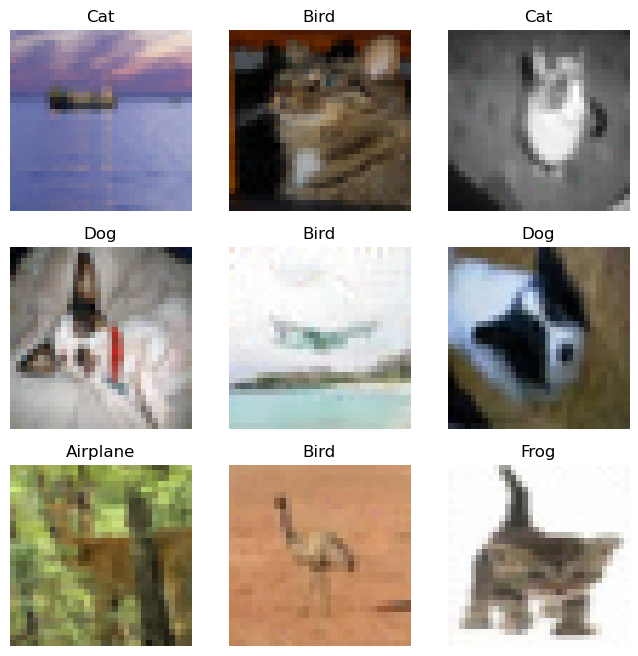

In [16]:
soft_max = nn.Softmax(dim=1)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
Fragile_img = torch.load('./samples/cifar10/demonstrate_img')
# print(Fragile_img.shape)
Fragile_label = torch.load('./samples/cifar10/demonstrate_label')
# print(Fragile_label)
Fragile_img = Fragile_img.detach().cpu()
Fragile_label = soft_max(Fragile_label).argmax(1).detach().cpu().numpy()
# print(Fragile_label.shape)
for i in range(1, cols * rows + 1):
    img = Fragile_img[i-1]
    label = Fragile_label[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze())
plt.show()

# 预测概率直方图

tensor([[ 2.5479e-02,  2.6706e-02, -1.7635e-02,  6.1214e-02, -5.3914e-02,
          2.4178e-02,  1.1567e-02, -2.0447e-02, -7.1863e-02,  1.4485e-02],
        [ 7.0102e-02, -3.7435e-02,  7.3515e-02,  3.2198e-02,  4.9008e-02,
         -3.4959e-02, -5.7389e-02, -5.1662e-02, -2.3682e-02, -1.9950e-02],
        [-2.0691e+00, -3.5333e+00, -1.6218e+00,  8.3791e+00, -1.2520e+00,
          8.1722e+00, -1.5298e+00, -1.9785e+00, -1.5666e+00, -3.0003e+00],
        [-2.7924e-02,  2.2151e-02, -6.6168e-02,  1.8973e-02, -1.4693e-02,
          5.0578e-02, -7.4697e-03,  1.1980e-02, -7.3166e-04,  1.3029e-02],
        [ 4.8558e-02, -6.6804e-02,  9.4188e-02,  9.5426e-03,  4.5478e-02,
          6.5929e-03, -2.3962e-02, -1.8228e-02, -2.7937e-02, -6.7669e-02],
        [ 3.3424e-02, -2.9681e-03,  1.4342e-02,  1.3896e-02,  2.8404e-02,
          3.8718e-02, -6.8714e-03, -4.1683e-02, -1.5383e-02, -6.2163e-02],
        [ 4.3949e-02, -4.2394e-03,  3.5369e-02, -3.0160e-02, -3.6931e-02,
         -4.5066e-02,  2.9835e-0

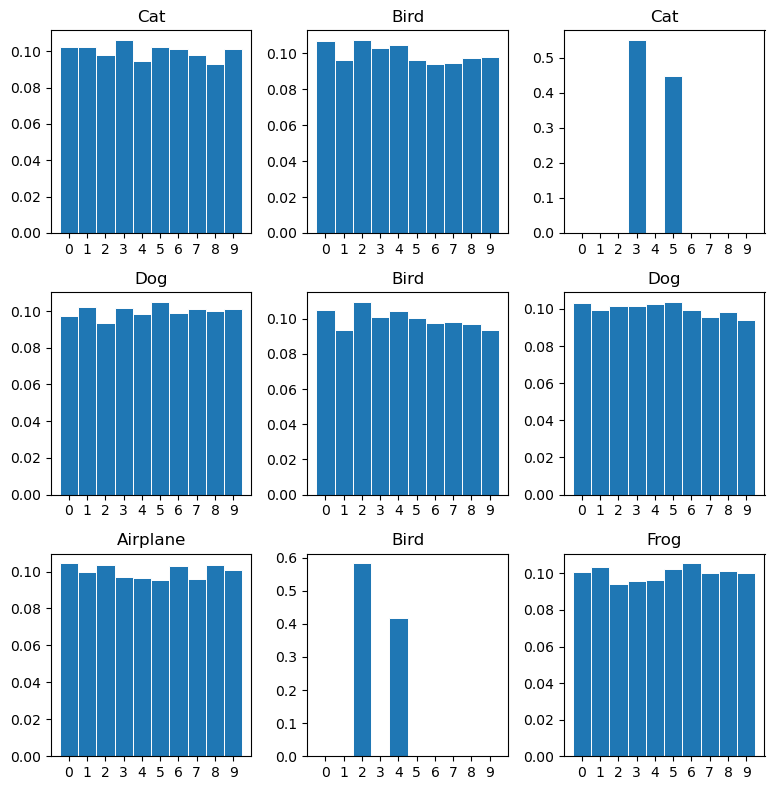

In [17]:
soft_max = nn.Softmax(dim=1)
l_x = ['0','1','2','3','4','5','6','7','8','9']
yticks = np.linspace(0, 1., 5)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
Fragile_label = torch.load('./samples/cifar10/demonstrate_label')
print(Fragile_label)
Fragile_label_value = soft_max(Fragile_label).detach().cpu().numpy()
Fragile_label = soft_max(Fragile_label).argmax(1).detach().cpu().numpy()
print(Fragile_label.shape)
for i in range(1, cols * rows + 1):
    img = Fragile_img[i-1]
    label = Fragile_label[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
#     plt.axis("off")
    yticks = np.linspace(0, 1., 5)
    plt.tight_layout()
    plt.bar(l_x, Fragile_label_value[i-1], width=1, edgecolor="white", linewidth=0.7)
plt.show()